# Import Data 

To help us make useful predictions, we make use of data such as banners, events, and story releases. All data is split by JP / EN.

## Revenue Data

Please refer to the excel for more information.

In [654]:
import pandas as pd
reddit_data = pd.read_excel('./data/reddit-monthly-revenue-report.xlsx').iloc[:, :3]
ennead_data = pd.read_excel('./data/revenue-ennead-cc-revenue-report.xlsx')

In [655]:
revenue = pd.concat([reddit_data, ennead_data], ignore_index=True)
revenue

,Date,JP,Global
0,2021-02-01,NaN,NaN
1,2021-03-01,NaN,NaN
2,2021-04-01,NaN,NaN
3,2021-05-01,NaN,NaN
4,2021-06-01,NaN,NaN
5,2021-07-01,NaN,NaN
6,2021-08-01,NaN,NaN
7,2021-09-01,NaN,NaN
8,2021-10-01,NaN,NaN
9,2021-11-01,3000000.0,NaN


In [656]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    54 non-null     datetime64[ns]
 1   JP      45 non-null     float64       
 2   Global  44 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.4 KB


## Banner Data

The info was sourced from here:
https://api.ennead.cc/buruaka/banner

In [657]:
import requests

banner_en = requests.get('https://api.ennead.cc/buruaka/banner').json()
all_banners_en = banner_en['ended'] + banner_en['current'] + banner_en['upcoming']
all_banners_en = pd.DataFrame(all_banners_en)

all_banners_en['startAt'] = pd.to_datetime(all_banners_en['startAt'], unit='ms')
all_banners_en['endAt'] = pd.to_datetime(all_banners_en['endAt'], unit='ms')
all_banners_en = all_banners_en.sort_values(by='startAt')
# all_banners_en

In [658]:
banner_jp = requests.get('https://api.ennead.cc/buruaka/banner?region=japan').json()
all_banners_jp = banner_jp['ended'] + banner_jp['current'] + banner_jp['upcoming']
all_banners_jp = pd.DataFrame(all_banners_jp)

all_banners_jp['startAt'] = pd.to_datetime(all_banners_jp['startAt'], unit='ms')
all_banners_jp['endAt'] = pd.to_datetime(all_banners_jp['endAt'], unit='ms')
all_banners_jp = all_banners_jp.sort_values(by='startAt')
all_banners_jp

,gachaType,startAt,endAt,rateups
1,PickupGacha,2021-02-04 08:00:00,2021-02-11 05:59:59,"[シロコ, ホシノ]"
2,PickupGacha,2021-02-11 07:00:00,2021-02-25 06:01:00,[マシロ]
3,PickupGacha,2021-02-25 06:30:00,2021-03-11 04:00:00,"[イズナ, シズコ]"
0,PickupGacha,2021-03-07 04:30:00,2021-04-29 04:00:00,[チェリノ]
4,PickupGacha,2021-03-11 04:30:00,2021-03-18 04:00:00,[ハルナ]
...,...,...,...,...
389,LimitedGacha,2025-09-03 03:00:00,2025-09-17 02:59:59,[サオリ（水着）]
392,PickupGacha,2025-09-03 03:00:00,2025-09-17 02:59:59,[ノノミ（水着）]
394,LimitedGacha,2025-09-17 03:00:00,2025-09-24 02:59:59,[カリン（バニーガール）]
393,LimitedGacha,2025-09-17 03:00:00,2025-09-24 02:59:59,[ネル（バニーガール）]


## Story Release

The info was sourced from here:
https://bluearchive.fandom.com/wiki/Story/Main_Story

Unfortunately, only the JP dates are available.

In [659]:
story_jp = pd.read_excel('./data/story-jp.xlsx').iloc[:, :5]
story_jp.head()
# story_jp.info()

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,NaN,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00


## Event Schedule

The data was sourced from here: https://bluearchive.wiki/wiki/Events

In [660]:
event_en = pd.read_excel('./data/event-en.xlsx')
event_jp = pd.read_excel('./data/event-jp.xlsx').iloc[:, :5]
# event_en
event_jp

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,NaN
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,NaN
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,NaN
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,NaN
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,NaN
...,...,...,...,...,...
79,A Flower Blooms Among The Hundred ～ Honorable ...,百ヨリ出ズル一輪ノ～いざ尋常に、水上勝負～,2025-06-25,2025-07-09,NaN
80,Summer Sky's Promise,夏空のやくそく,2025-07-22,2025-08-06,NaN
81,Say-Bing!,Say-Bing!,2025-08-06,2025-08-13,NaN
82,We are the Occult Research Society! ～Academy M...,我らオカルト研究会！～学院の不思議と古の呪文～,2025-08-20,2025-09-03,NaN


# EDA

## Sales Overview

In [661]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib 

import seaborn as sns

def millions_formatter(x, pos):
    '''
    Format the y-axis ticks to show millions.
    '''
    return f'{x * 1e-6:.1f}M'

def plot_revenue_monthly(df: pd.DataFrame, region: str = 'JP'):
    '''
    Plot the monthly revenue time series with one subplot per year.
    df: revenue DataFrame
    region: string, the region to plot (default is 'JP')
    '''
    # Ensure 'Date' is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values(by='Date')
    
    # Extract unique years
    years = df['Date'].dt.year.unique()
    
    # Create subplots: one row per year
    fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)), sharey=True)
    
    for ax, year in zip(axes, years):
        subset = df[df['Date'].dt.year == year]
        sns.lineplot(data=subset, x='Date', y=region, ax=ax)
        
        # Format y-axis in millions
        ax.yaxis.set_major_formatter(millions_formatter)
        
        # X-axis: one tick per month
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=45)
        
        # Set title
        ax.set_title(f'Revenue for {region} ({year})')

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_revenue_yearly(df: pd.DataFrame, region: str = 'JP', events_df: pd.DataFrame = None, step: bool = False, 
                        custom_plotter=None, label: bool = False, legend: bool = False):
    '''
    Plot the yearly revenue time series.

    Parameters
    ----------
    df: pd.DataFrame
        revenue DataFrame

    region: str
        string, the region to plot (default is 'JP')

    events_df: pd.DataFrame, optional
        DataFrame containing event data (default is None)
        Events refer to significant occurrences that may impact revenue (e.g., game releases, updates).

    step: bool
        Whether to use step plotting (default is False)

    custom_plotter: callable, optional
        Optional custom plotting function. Takes matplotlib Axes object and plots extra things.

    label: bool
        Whether to label the events with the custom plotter (default is False)

    legend: bool
        Whether to show the legend (default is False)
    '''

    # Ensure 'Date' is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values(by='Date')

    # Adjust Size
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    if step:
        # Step plot
        ax.step(df['Date'], df[region], where='post')
    else:
        # Regular lineplot
        sns.lineplot(data=df, x='Date', y=region, ax=ax)

    # Format y-axis in millions
    ax.yaxis.set_major_formatter(millions_formatter)
    
    # X-axis: one tick per year
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set title
    ax.set_title(f'Revenue for {region}')

    if custom_plotter:
        custom_plotter(ax, events_df, label)

    if legend:
        plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [662]:
plt.rcParams['font.family'] = ['Yu Gothic', 'MS Gothic', 'Meiryo', 'Arial']
# plt.rcParams['font.weight'] = 'bold'

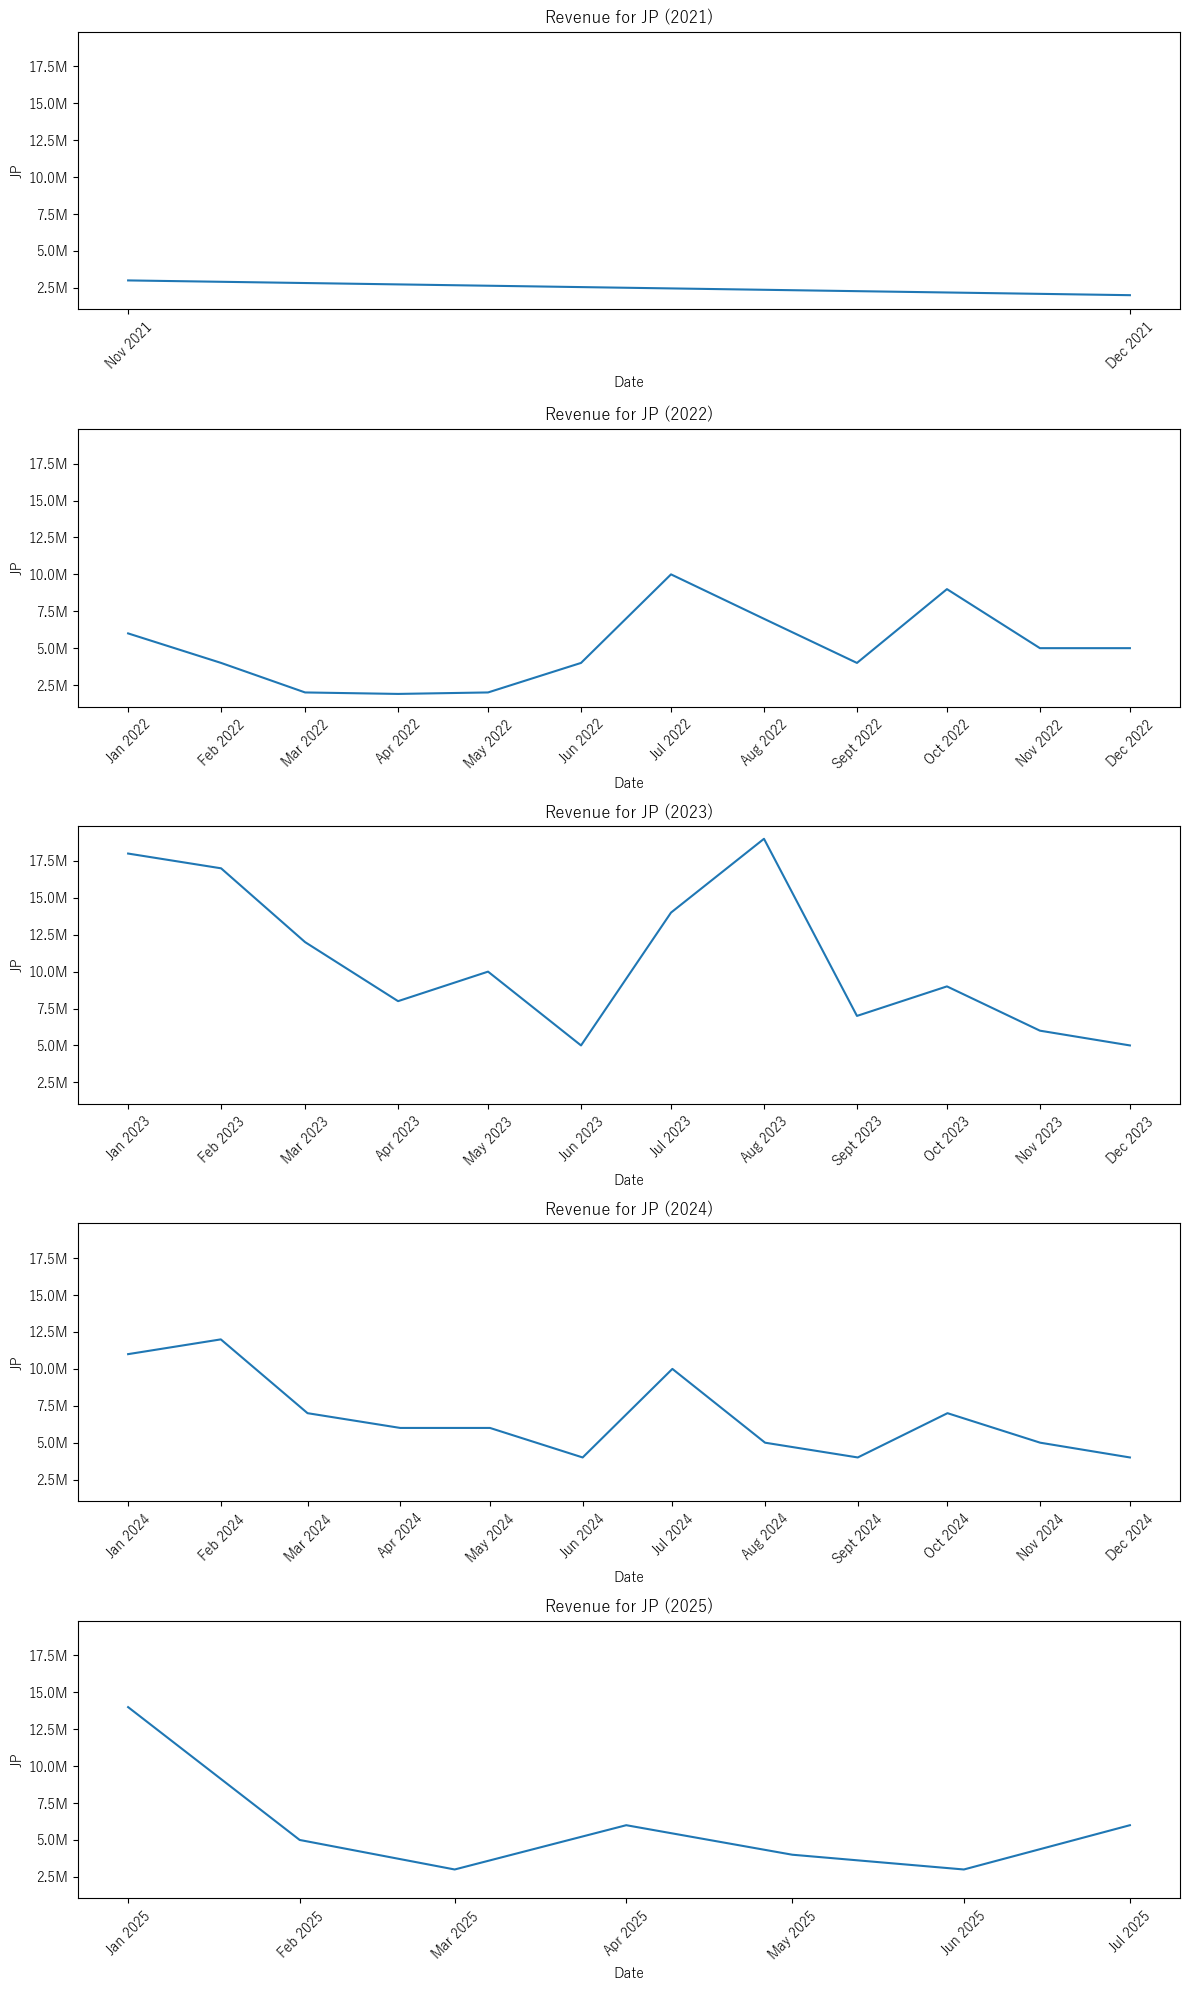

In [663]:
plot_revenue_monthly(revenue)

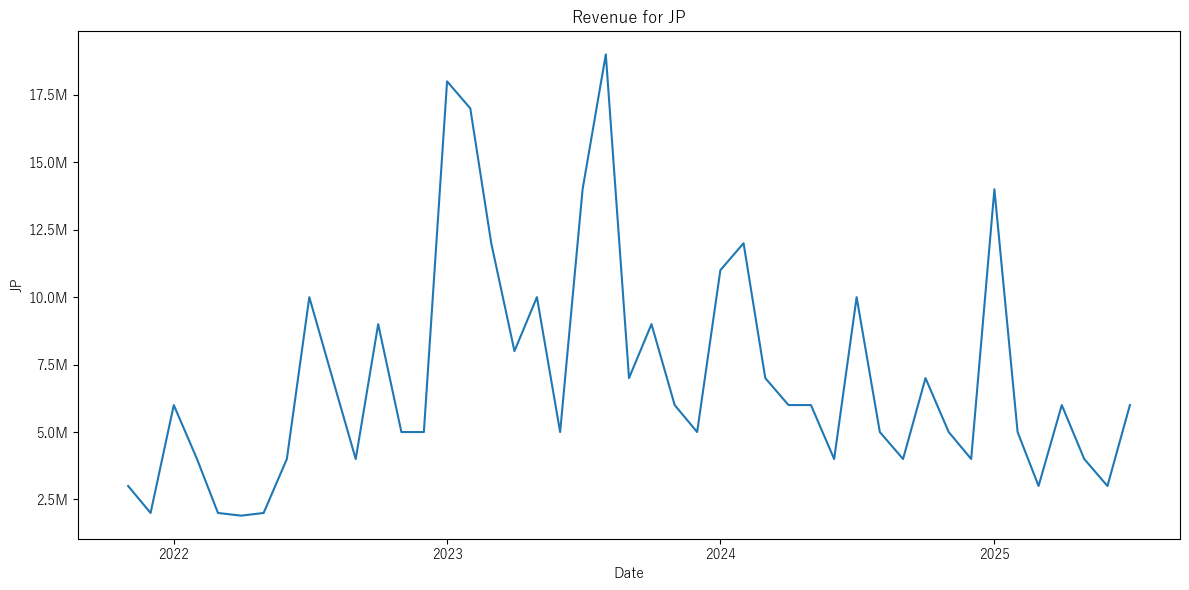

In [664]:
plot_revenue_yearly(revenue)

The game appears to have peak revenue at in the year of 2023, reaching up to 19M in sales. 

Furthermore, there appears to be seasonality in the data; for every year, there seems to be:
- a spike near the start of the year 
- a spike near the July-Aug period.

## Impact of Events

We take event to be some sort of feature that has at least a start date. Logically speaking, certain events ought to drive sales. For example, if there is a Festival Banner I would expect sales to spike for that month. Let's have a look at the impact of some events:

In [665]:
all_banners_jp['gachaType'].unique()

array(['PickupGacha', 'LimitedGacha', 'FesGacha'], dtype=object)

### Banners

In simple terms, when a banner is ongoing, you are able to participate in a 'lottery' (i.e. gacha) to stand a chance of getting the character you want. There are 3 types of gachas:

- Pickup: You have a higher chance of getting a particular character. However, that character can also be obtained (randomly) through any of the 3 types of gacha. Therefore, as long as you participate in any type of gacha there is some chance of obtaining that character. 

- Limited: You can only obtain the character during the banner period. If you miss it, you can't obtain it unless the banner appears again in the future.

- Festival: A banner designed to celebrate milestones (such as a 3rd anniversary, for example.) This banner works the same as a Limited, but typically features the most popular and powerful characters. 

In [666]:
all_banners_jp.head()

,gachaType,startAt,endAt,rateups
1,PickupGacha,2021-02-04 08:00:00,2021-02-11 05:59:59,"[シロコ, ホシノ]"
2,PickupGacha,2021-02-11 07:00:00,2021-02-25 06:01:00,[マシロ]
3,PickupGacha,2021-02-25 06:30:00,2021-03-11 04:00:00,"[イズナ, シズコ]"
0,PickupGacha,2021-03-07 04:30:00,2021-04-29 04:00:00,[チェリノ]
4,PickupGacha,2021-03-11 04:30:00,2021-03-18 04:00:00,[ハルナ]


In [667]:
GACHA_COLORS = {
    'PickupGacha' : 'lightblue',
    'LimitedGacha' : 'orange',
    'FesGacha' : 'pink'
}

In [668]:
def banner_region_plotter(ax: matplotlib.axes.Axes, event_df: pd.DataFrame, label: bool = False):
    '''
    A helper to plot banners on the yearly chart.
    All banners should be of a single type (so for example, event_df 
    can be something like fes_banners_jp, which contains only the 
    fes banners.)

    Parameters          
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to plot the banners.
    event_df : pd.DataFrame
        Banner of a specific type (e.g. FesGacha)
    label: Whether to label the banners.
        Too much labelling might be a little messy.
    '''

    color = GACHA_COLORS.get(event_df['gachaType'].iloc[0], 'gray')

    grouped = (event_df.groupby(['startAt', 'endAt']))['rateups']
    grouped = grouped.apply(lambda x: "\n".join(map(str, x))) # rateups is a list of strings.
    grouped = grouped.reset_index() # removes the multiindex, returning a df
    
    for _, row in grouped.iterrows():
        ax.axvspan(row['startAt'], row['endAt'], color=color, alpha=0.3)
        if label:
            ax.text(
                row['startAt'], # x position
                ax.get_ylim()[1]*0.95,   # y_position (top of the plot)
                row['rateups'], 
                # color=color,
            fontsize=9,
            verticalalignment='top'
        )

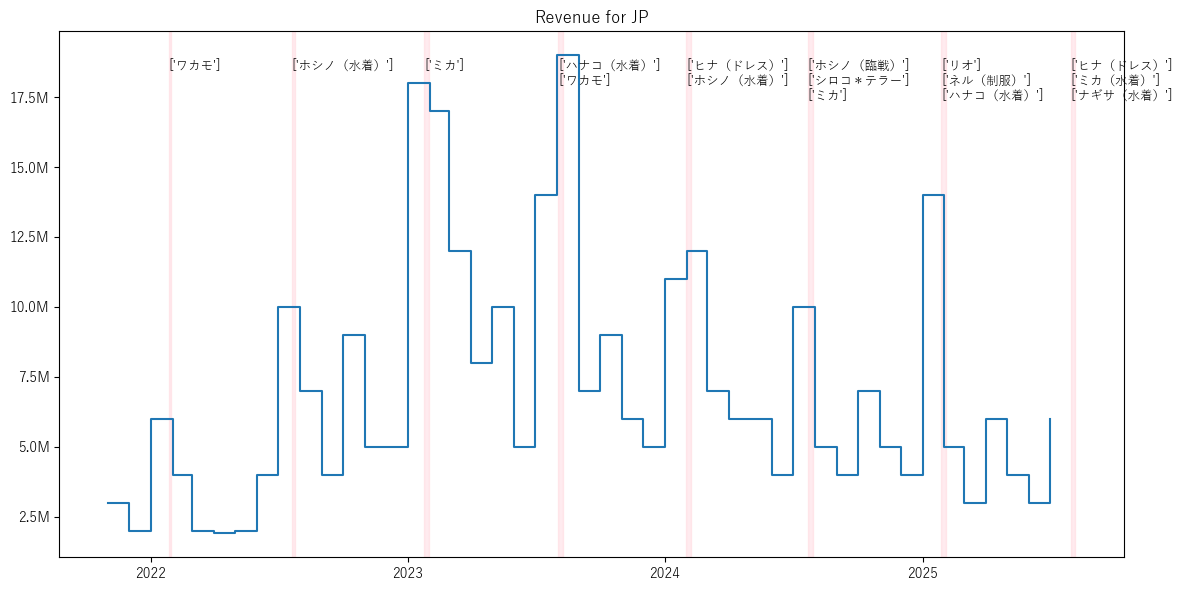

In [669]:
fes_banners_jp = all_banners_jp[all_banners_jp['gachaType'] == 'FesGacha']
plot_revenue_yearly(df=revenue, region='JP', events_df=fes_banners_jp, step=True, custom_plotter=banner_region_plotter, label=True)

In [670]:
fes_banners_jp

,gachaType,startAt,endAt,rateups
35,FesGacha,2022-01-26 04:30:00,2022-01-30 03:59:59,[ワカモ]
67,FesGacha,2022-07-20 03:00:00,2022-07-25 02:59:59,[ホシノ（水着）]
111,FesGacha,2023-01-24 03:00:00,2023-01-31 02:59:59,[ミカ]
158,FesGacha,2023-08-02 03:00:00,2023-08-09 02:59:59,[ハナコ（水着）]
159,FesGacha,2023-08-02 03:00:00,2023-08-09 02:59:59,[ワカモ]
212,FesGacha,2024-01-31 03:00:00,2024-02-07 02:59:59,[ヒナ（ドレス）]
213,FesGacha,2024-01-31 03:00:00,2024-02-07 02:59:59,[ホシノ（水着）]
266,FesGacha,2024-07-22 03:00:00,2024-07-29 02:59:59,[ホシノ（臨戦）]
267,FesGacha,2024-07-22 03:00:00,2024-07-29 02:59:59,[シロコ＊テラー]
268,FesGacha,2024-07-22 03:00:00,2024-07-29 02:59:59,[ミカ]


As expected, Fes banners drive the most sales. Local peaks correspond nicely to the release dates of the fest banners (region in pink), and this is probably the single best predictive feature. 
Players won't know the upcoming characters in advance, so they have to purchase resources when the character is released (if they have insufficient resources).

The most popular banners appear to be for:
- Mika (Jan 23)
- S. Hanako (Aug 23)

The above characters happen to be quite popular (and powerful in game too!)

Translation of the names will be handled a little later.

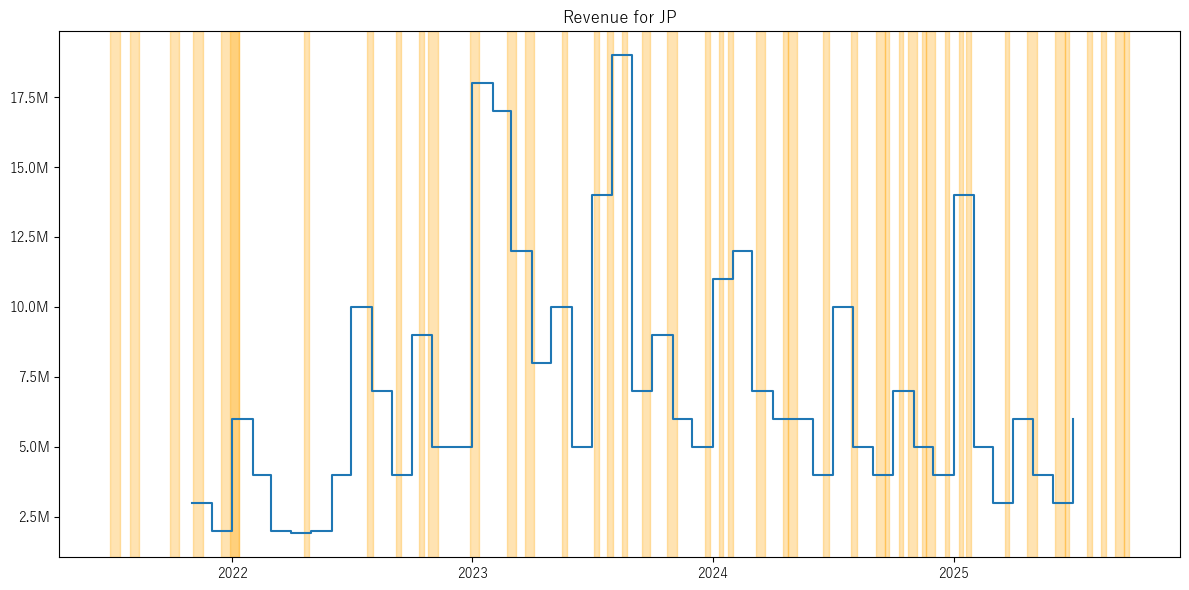

In [671]:
limited_banners_jp = all_banners_jp[all_banners_jp['gachaType'] == 'LimitedGacha']
plot_revenue_yearly(df=revenue, region='JP', events_df=limited_banners_jp, step=True, custom_plotter=banner_region_plotter, label=False)

Troughs do not appear to have many limited banners, in general. So it might be the case that when there are multiple limited banners close to each other, revenue tends to be higher. Players might have insufficient resources to obtain these characters back to back, forcing them to make a purchase. 

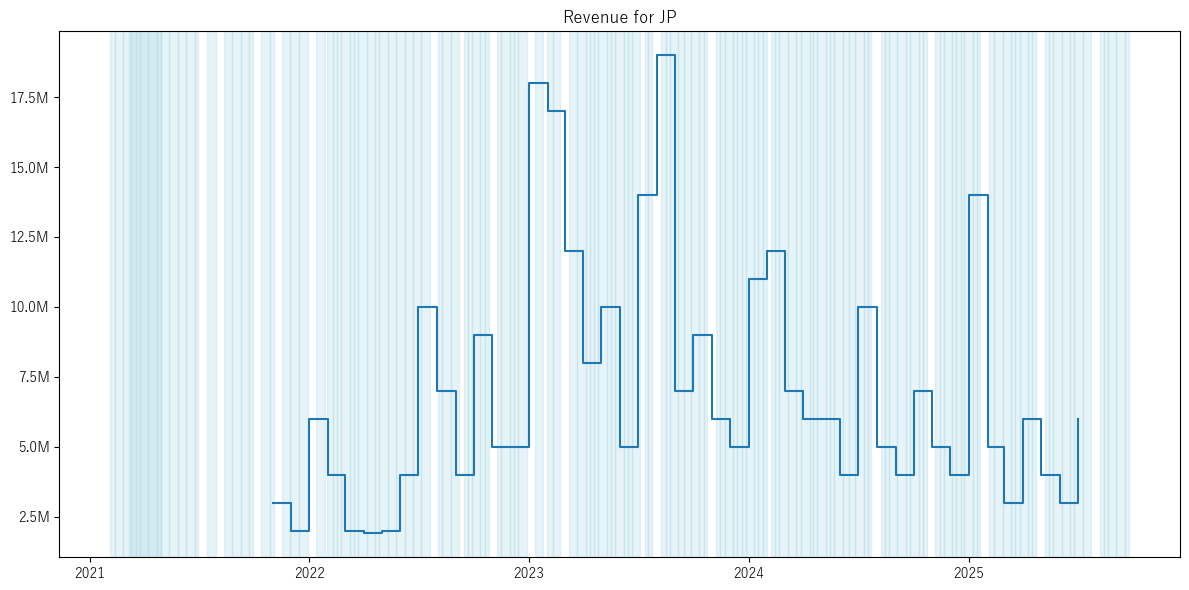

In [672]:
pickup_banners_jp = all_banners_jp[all_banners_jp['gachaType'] == 'PickupGacha']
plot_revenue_yearly(df=revenue, region='JP', events_df=pickup_banners_jp, step=True, custom_plotter=banner_region_plotter, label=False)

There doesn't seem to much relation between pick-up banners and revenue.

### Story

In [673]:
story_jp

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,NaN,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00
5,1,The Foreclosure Task Force,3,2.0,2024-05-06 00:00:00
6,1,The Foreclosure Task Force,3,3.0,2024-06-19 00:00:00
7,1,The Foreclosure Task Force,3,4.0,2024-07-17 00:00:00
8,1,The Foreclosure Task Force,3,5.0,2024-07-22 00:00:00
9,2,Clockwork Flower Pavane,1,NaN,2021-03-25 00:00:00


In [674]:
import matplotlib.cm as cm
import numpy as np

colors = sns.color_palette("Set2", len(story_jp['Full Name'].unique()))
color_dict = dict(zip(story_jp['Full Name'].unique(), colors))
# color_dict

In [675]:
def story_plotter(ax: matplotlib.axes.Axes, event_df: pd.DataFrame, label: bool = False):
    '''
    A helper to plot the story release dates on the yearly chart.

    Parameters          
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to plot the banners.
    event_df : pd.DataFrame
        df containing story info.
    label: Whether to label the story.
        Too much labelling might be a little messy.
    '''

    labelled_stories = set()
    
    for _, row in event_df.iterrows():
        release_date = pd.to_datetime(row['Release Date'])
        story_name = row['Full Name']
        
        if story_name not in labelled_stories: 

            if label:
                ax.text(
                    release_date, # x position
                    ax.get_ylim()[1]*0.95,   # y_position (top of the plot)
                    story_name,
                    fontsize=9,
                    verticalalignment='top'
                )

            ax.axvline(release_date, color=color_dict[story_name], alpha=0.85, label=story_name)
            labelled_stories.add(story_name)
        else:
            ax.axvline(release_date, color=color_dict[story_name], alpha=0.85)



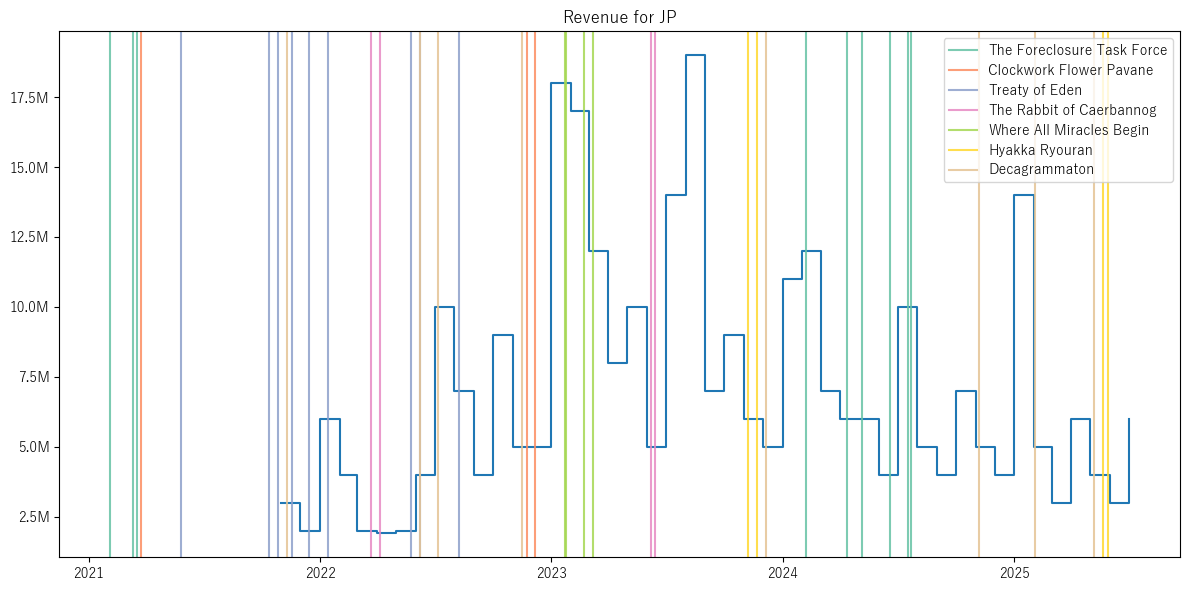

In [676]:
plot_revenue_yearly(revenue, events_df=story_jp, step=True, custom_plotter=story_plotter, label=False, legend=True)

Some stories we know are popular (e.g. Foreclosure Task Force, Where All Miracles Begin), while others may not be as popular. Popular stories may or may not be associated with higher revenue. A possible approach might be to create features:
- number of stories this month 
- is there a popular story this month 

Of course, it's hard to predict if a story will be popular in the future, so we can leave that as 0 unless we have strong reason to believe otherwise. 

### Event

In [677]:
event_jp

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,NaN
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,NaN
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,NaN
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,NaN
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,NaN
...,...,...,...,...,...
79,A Flower Blooms Among The Hundred ～ Honorable ...,百ヨリ出ズル一輪ノ～いざ尋常に、水上勝負～,2025-06-25,2025-07-09,NaN
80,Summer Sky's Promise,夏空のやくそく,2025-07-22,2025-08-06,NaN
81,Say-Bing!,Say-Bing!,2025-08-06,2025-08-13,NaN
82,We are the Occult Research Society! ～Academy M...,我らオカルト研究会！～学院の不思議と古の呪文～,2025-08-20,2025-09-03,NaN


In [678]:
EVENT_COLORS = dict(zip(['Collaboration Event', 'Rerun', 'Operation'], sns.color_palette('hls', 3)))

def classify_event(event: str) -> str:
    '''
    Classify the event type based on its name.

    Parameters
    ----------
    event : str
        The name of the event.

    Returns
    -------
    str
        The category of the event.
    '''
    if type(event) is not str:
        return 'Other'
    if 'collab' in event.lower():
        return 'Collaboration Event'
    elif 'rerun' in event.lower():
        return 'Rerun'
    elif 'operation' in event.lower():
        return 'Operation'
    else: 
        return 'Other'

In [679]:
def event_plotter(ax: matplotlib.axes.Axes, event_df: pd.DataFrame, label: bool = False):
    '''
    A helper to plot game events on the yearly chart.

    Parameters          
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to plot the banners.
    event_df : pd.DataFrame
        df containing game event information. 
    label: Whether to label the banners.
        Too much labelling might be a little messy.
    '''

    labelled_events = set()
    
    for _, row in event_df.iterrows():
        event_type = classify_event(row['Notes'])
        if event_type not in labelled_events:
            ax.axvspan(row['Start date'], row['End date'], color=EVENT_COLORS.get(event_type, 'gray'), alpha=0.3, label=event_type)
            labelled_events.add(event_type) 
        else: 
            ax.axvspan(row['Start date'], row['End date'], color=EVENT_COLORS.get(event_type, 'gray'), alpha=0.3)

Let's have a look at rerun events:

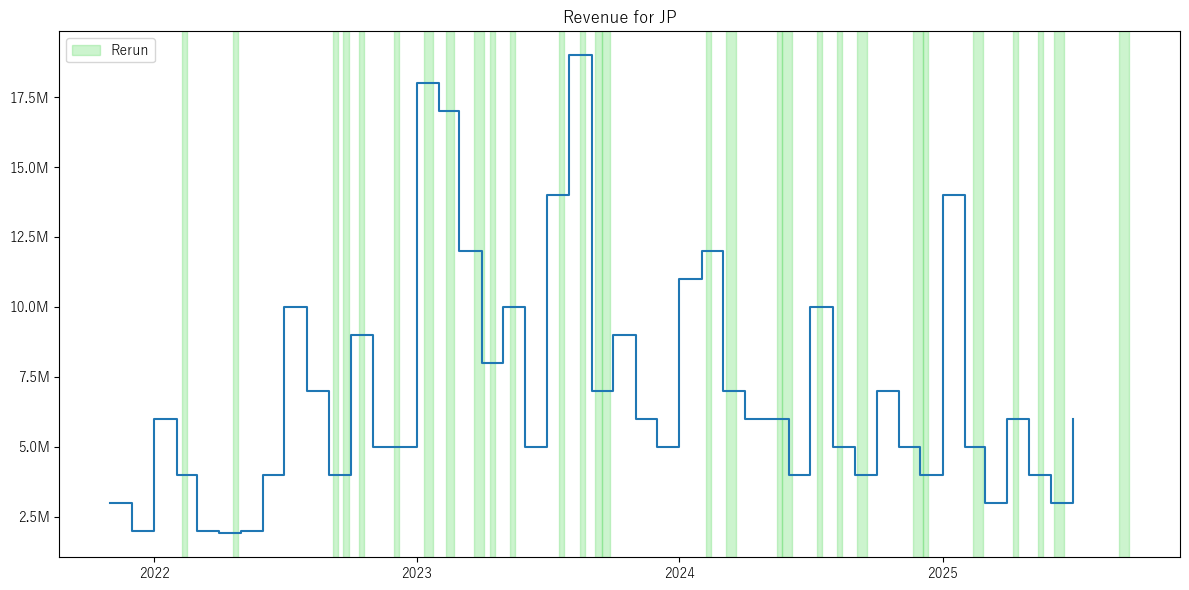

In [680]:
rerun_events = event_jp[event_jp['Notes'].apply(classify_event) == 'Rerun']
plot_revenue_yearly(revenue, events_df=rerun_events, step=True, custom_plotter=event_plotter, legend=True)

It seems like rerun events are often associated with 'dead weeks' where there is no new content. Therefore, I would expect revenue to be lower when rerun events occur.

Next, let's have a look at original events (events that occur for the first time).

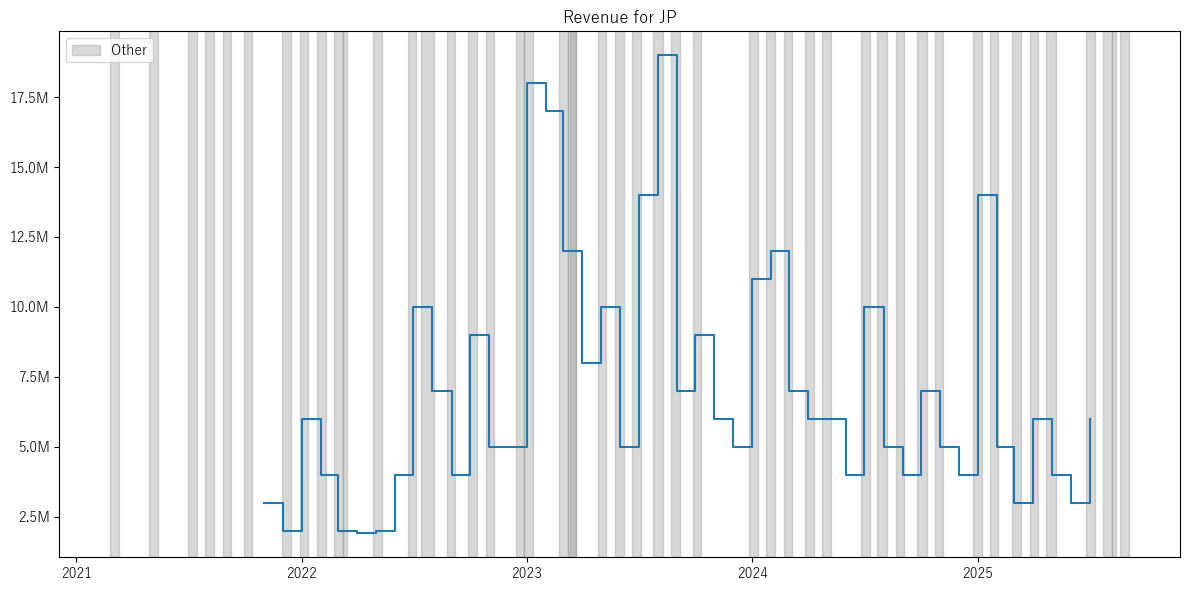

In [681]:
rerun_events = event_jp[event_jp['Notes'].apply(classify_event) == 'Other']
plot_revenue_yearly(revenue, events_df=rerun_events, step=True, custom_plotter=event_plotter, legend=True)

# Data Cleaning

## Revenue Data

We will not be working with global data from now on. Some reasons include: 

- Lack of data
- Accelerated Schedule
- Not the most recent updates and characters

In [682]:
revenue = revenue.drop(columns=['Global']).dropna().reset_index(drop=True)
revenue

,Date,JP
0,2021-11-01,3000000.0
1,2021-12-01,2000000.0
2,2022-01-01,6000000.0
3,2022-02-01,4000000.0
4,2022-03-01,2000000.0
5,2022-04-01,1900000.0
6,2022-05-01,2000000.0
7,2022-06-01,4000000.0
8,2022-07-01,10000000.0
9,2022-08-01,6989822.0


## Banner Data

We don't really need to know the character's name, just the gacha type and date. Hence, we will leave the banner data as is and ignore any possible translation issues.

In [683]:
all_banners_jp

,gachaType,startAt,endAt,rateups
1,PickupGacha,2021-02-04 08:00:00,2021-02-11 05:59:59,"[シロコ, ホシノ]"
2,PickupGacha,2021-02-11 07:00:00,2021-02-25 06:01:00,[マシロ]
3,PickupGacha,2021-02-25 06:30:00,2021-03-11 04:00:00,"[イズナ, シズコ]"
0,PickupGacha,2021-03-07 04:30:00,2021-04-29 04:00:00,[チェリノ]
4,PickupGacha,2021-03-11 04:30:00,2021-03-18 04:00:00,[ハルナ]
...,...,...,...,...
389,LimitedGacha,2025-09-03 03:00:00,2025-09-17 02:59:59,[サオリ（水着）]
392,PickupGacha,2025-09-03 03:00:00,2025-09-17 02:59:59,[ノノミ（水着）]
394,LimitedGacha,2025-09-17 03:00:00,2025-09-24 02:59:59,[カリン（バニーガール）]
393,LimitedGacha,2025-09-17 03:00:00,2025-09-24 02:59:59,[ネル（バニーガール）]


## Story Data

Some chapters don't come with a part. For now, let's impute the missing values with 'None', since the missing values are actually story chapters with no part.

In [684]:
story_jp['Part'] = story_jp['Part'].astype(object)
story_jp['Part'] = story_jp['Part'].fillna('None')
story_jp

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,None,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00
5,1,The Foreclosure Task Force,3,2.0,2024-05-06 00:00:00
6,1,The Foreclosure Task Force,3,3.0,2024-06-19 00:00:00
7,1,The Foreclosure Task Force,3,4.0,2024-07-17 00:00:00
8,1,The Foreclosure Task Force,3,5.0,2024-07-22 00:00:00
9,2,Clockwork Flower Pavane,1,None,2021-03-25 00:00:00


## Event Data

It appears that some of the events are inconsistently named. Looking at the Name (EN) column, some events have (Rerun) affixed to them while others don't. For consistency, we will remove the '(Rerun) ' prefix and rely on the 'Notes' column to tell us whether an event is a rerun or not. For simplicity, we will leave Name (JP) alone.

In [685]:
event_jp.iloc[11]

Name (EN)     (Rerun) Cherry Blossom Festival Commotion! ~Fl...
Name (JP)                             【復刻】桜花爛漫お祭り騒ぎ！～空に徒花 地に忍び～
Start date                                  2022-02-09 00:00:00
End date                                    2022-02-16 00:00:00
Notes                                                     Rerun
Name: 11, dtype: object

In [686]:
event_jp['Name (EN)'] = event_jp['Name (EN)'].str.removeprefix('(Rerun) ')
event_jp.iloc[11]

Name (EN)     Cherry Blossom Festival Commotion! ~Flowers in...
Name (JP)                             【復刻】桜花爛漫お祭り騒ぎ！～空に徒花 地に忍び～
Start date                                  2022-02-09 00:00:00
End date                                    2022-02-16 00:00:00
Notes                                                     Rerun
Name: 11, dtype: object

Furthermore, it looks like some events weren't marked properly as 'rerun'. When events are rerun, it means an in-game event that occured before occurs again. This might not be the most exciting event for players. Let's mark any event that has appeared once as 'rerun'.

In [687]:
event_jp.iloc[60]

Name (EN)               Say-Bing!
Name (JP)               Say-Bing!
Start date    2024-06-26 00:00:00
End date      2024-07-10 00:00:00
Notes                         NaN
Name: 60, dtype: object

In [688]:
event_jp.iloc[81] # same event appears twice but not marked as rerun

Name (EN)               Say-Bing!
Name (JP)               Say-Bing!
Start date    2025-08-06 00:00:00
End date      2025-08-13 00:00:00
Notes                         NaN
Name: 81, dtype: object

Using the `duplicated` method, we can conveniently replace everything else with 'Original' too.

In [689]:
original_or_rerun = event_jp['Name (EN)'].duplicated().map({True: 'Rerun', False: 'Original'})
event_jp['Notes'] = event_jp['Notes'].fillna(original_or_rerun)
event_jp

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,Original
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,Original
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,Original
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,Original
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,Original
...,...,...,...,...,...
79,A Flower Blooms Among The Hundred ～ Honorable ...,百ヨリ出ズル一輪ノ～いざ尋常に、水上勝負～,2025-06-25,2025-07-09,Original
80,Summer Sky's Promise,夏空のやくそく,2025-07-22,2025-08-06,Original
81,Say-Bing!,Say-Bing!,2025-08-06,2025-08-13,Rerun
82,We are the Occult Research Society! ～Academy M...,我らオカルト研究会！～学院の不思議と古の呪文～,2025-08-20,2025-09-03,Original


Lastly, let's just group all the 'operations' events together:

In [690]:
event_jp.loc[event_jp["Notes"].str.contains("Operation", case=False, na=False), "Notes"] = "Operation"
event_jp

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,Original
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,Original
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,Original
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,Original
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,Original
...,...,...,...,...,...
79,A Flower Blooms Among The Hundred ～ Honorable ...,百ヨリ出ズル一輪ノ～いざ尋常に、水上勝負～,2025-06-25,2025-07-09,Original
80,Summer Sky's Promise,夏空のやくそく,2025-07-22,2025-08-06,Original
81,Say-Bing!,Say-Bing!,2025-08-06,2025-08-13,Rerun
82,We are the Occult Research Society! ～Academy M...,我らオカルト研究会！～学院の不思議と古の呪文～,2025-08-20,2025-09-03,Original


# Feature Engineering

Since we are doing a forecasting event, we want each row of data to be one month of data. Of course, some data (such as banner release dates) don't exactly start at the start of the month and end at the end of the month, so we need to make some adjustments.

## Banner Data

We aim to group the banner data by month.

In this approach, an banner that occurs from 27 March to 1st April will be counted in both March and April.

In [691]:
def group_into_monthly_count(banners: pd.DataFrame) -> pd.DataFrame:
    '''
    Group the banner events into monthly counts.

    For example, if 3 banners occur during March 2023, the 
    result will have a row for March 2023 with a count of 3.

    Parameters
    ----------
    banners : pd.DataFrame
        The input DataFrame containing banner event data.

    Returns
    -------
    pd.DataFrame
        A DataFrame with monthly counts of banner events.
    '''
    
    monthly_count = pd.DataFrame(revenue['Date'])
    monthly_count['Banner Count'] = 0
    for banner in banners.iterrows():
        start_month = banner[1]['startAt'].to_period('M').to_timestamp()
        end_month = banner[1]['endAt'].to_period('M').to_timestamp()
        if start_month == end_month:
            if start_month in monthly_count['Date'].values:
                monthly_count.loc[monthly_count['Date'] == start_month, 'Banner Count'] += 1
        else:
            if start_month in monthly_count['Date'].values:
                monthly_count.loc[monthly_count['Date'] == start_month, 'Banner Count'] += 1
            if end_month in monthly_count['Date'].values:
                monthly_count.loc[monthly_count['Date'] == end_month, 'Banner Count'] += 1

    return monthly_count

In [692]:
revenue

,Date,JP
0,2021-11-01,3000000.0
1,2021-12-01,2000000.0
2,2022-01-01,6000000.0
3,2022-02-01,4000000.0
4,2022-03-01,2000000.0
5,2022-04-01,1900000.0
6,2022-05-01,2000000.0
7,2022-06-01,4000000.0
8,2022-07-01,10000000.0
9,2022-08-01,6989822.0


In [693]:
monthly_count_pickup_jp = group_into_monthly_count(pickup_banners_jp)
monthly_count_pickup_jp.rename(columns={'Banner Count': 'Pickup Banner Count'}, inplace=True)

monthly_count_limited_jp = group_into_monthly_count(limited_banners_jp)
monthly_count_limited_jp.rename(columns={'Banner Count': 'Limited Banner Count'}, inplace=True)

monthly_count_fes_jp = group_into_monthly_count(fes_banners_jp)
monthly_count_fes_jp.rename(columns={'Banner Count': 'Fes Banner Count'}, inplace=True)

# example: 
monthly_count_pickup_jp

,Date,Pickup Banner Count
0,2021-11-01,4
1,2021-12-01,3
2,2022-01-01,3
3,2022-02-01,8
4,2022-03-01,8
5,2022-04-01,7
6,2022-05-01,6
7,2022-06-01,6
8,2022-07-01,4
9,2022-08-01,6


In [694]:
revenue = revenue.merge(monthly_count_pickup_jp, on='Date').merge(monthly_count_limited_jp, on='Date').merge(monthly_count_fes_jp, on='Date')
revenue

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count
0,2021-11-01,3000000.0,4,1,0
1,2021-12-01,2000000.0,3,2,0
2,2022-01-01,6000000.0,3,2,1
3,2022-02-01,4000000.0,8,0,0
4,2022-03-01,2000000.0,8,0,0
5,2022-04-01,1900000.0,7,2,0
6,2022-05-01,2000000.0,6,0,0
7,2022-06-01,4000000.0,6,0,0
8,2022-07-01,10000000.0,4,2,1
9,2022-08-01,6989822.0,6,2,0


## Story Data

We will adopt a similar 'count' approach as above. However, there is an issue with creating ordinal features (for example, with one-hot encoding). This is because our model doesn't really know what to do with unseen categories! 

Furthermore, from the above EDA there doesn't seem to be a clear relationship between story and revenue. 

To keep things simple, we will not include story data for now.

In [695]:
story_jp

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,None,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00
5,1,The Foreclosure Task Force,3,2.0,2024-05-06 00:00:00
6,1,The Foreclosure Task Force,3,3.0,2024-06-19 00:00:00
7,1,The Foreclosure Task Force,3,4.0,2024-07-17 00:00:00
8,1,The Foreclosure Task Force,3,5.0,2024-07-22 00:00:00
9,2,Clockwork Flower Pavane,1,None,2021-03-25 00:00:00


## Event Data

For this category, we will just sum up the amount ot each type of event by month and use that as a feature.

In [696]:
event_jp

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,Original
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,Original
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,Original
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,Original
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,Original
...,...,...,...,...,...
79,A Flower Blooms Among The Hundred ～ Honorable ...,百ヨリ出ズル一輪ノ～いざ尋常に、水上勝負～,2025-06-25,2025-07-09,Original
80,Summer Sky's Promise,夏空のやくそく,2025-07-22,2025-08-06,Original
81,Say-Bing!,Say-Bing!,2025-08-06,2025-08-13,Rerun
82,We are the Occult Research Society! ～Academy M...,我らオカルト研究会！～学院の不思議と古の呪文～,2025-08-20,2025-09-03,Original


In [697]:
def group_event_into_monthly_count(events: pd.DataFrame) -> pd.DataFrame:
    '''
    Group events into monthly counts.

    For example, if 3 events occur during March 2023, the 
    result will have a row for March 2023 with a count of 3.

    Parameters
    ----------
    events : pd.DataFrame
        The input DataFrame containing event data.

    Returns
    -------
    pd.DataFrame
        A DataFrame with monthly counts of events.
    '''
    
    monthly_count = pd.DataFrame(revenue['Date'])
    monthly_count['Event Count'] = 0
    for event in events.iterrows():
        start_month = event[1]['Start date'].to_period('M').to_timestamp()
        end_month = event[1]['End date'].to_period('M').to_timestamp()
        if start_month == end_month:
            if start_month in monthly_count['Date'].values:
                monthly_count.loc[monthly_count['Date'] == start_month, 'Event Count'] += 1
        else:
            if start_month in monthly_count['Date'].values:
                monthly_count.loc[monthly_count['Date'] == start_month, 'Event Count'] += 1
            if end_month in monthly_count['Date'].values:
                monthly_count.loc[monthly_count['Date'] == end_month, 'Event Count'] += 1

    return monthly_count

In [698]:
for event_type in event_jp['Notes'].unique():
    event_type_df = event_jp[event_jp['Notes'] == event_type]
    monthly_count_event_type = group_event_into_monthly_count(event_type_df)
    monthly_count_event_type.rename(columns={'Event Count': f'{event_type} Count'}, inplace=True)
    revenue = revenue.merge(monthly_count_event_type, on='Date')

revenue

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count
0,2021-11-01,3000000.0,4,1,0,1,1,1,0
1,2021-12-01,2000000.0,3,2,0,2,0,0,0
2,2022-01-01,6000000.0,3,2,1,2,0,0,0
3,2022-02-01,4000000.0,8,0,0,2,0,0,1
4,2022-03-01,2000000.0,8,0,0,1,0,0,1
5,2022-04-01,1900000.0,7,2,0,1,0,0,1
6,2022-05-01,2000000.0,6,0,0,1,0,0,0
7,2022-06-01,4000000.0,6,0,0,1,0,1,0
8,2022-07-01,10000000.0,4,2,1,2,0,1,0
9,2022-08-01,6989822.0,6,2,0,2,0,0,0


## Fourier Pairs 

We can use pairs of sin and cos curves as features to learn about seasonality. To put things very simply, by combining these curves together, we can create more detailed curves. 

In [699]:
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

A periodogram tells us the dominant frequencies of a signal. We will use this to determine which fourier pairs to include:

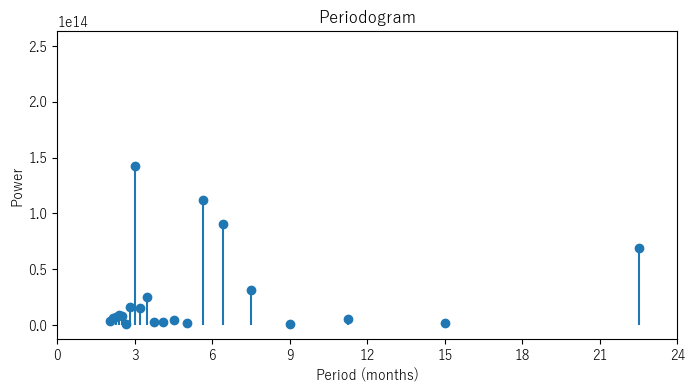

In [700]:
# Compute periodogram
freqs, power = periodogram(revenue['JP'])

# Plot
periods = 1 / freqs[1:]  # skip 0 frequency to avoid division by zero

plt.figure(figsize=(8,4))
plt.stem(periods, power[1:], basefmt=" ")
plt.xlabel("Period (months)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xticks(np.arange(0, 24+1, 3))
plt.xlim(0, 24)  
plt.show()

As we can see, the periodogram has peaks at 3 and 6 months. What that tells us is that there are probably 3 and 6 month cycles. The 6 month cycle is actually expected (due to the fact that Fes banners and many rewards tend to appear once every 6 months). 

Therefore, we will use 4th order calendar fourier to capture the shortest important cycle:
- order 1: 12 months
- order 2: 6 months
- order 3: 4 months 
- order 4: 3 months (stop here)

In [701]:
fourier = CalendarFourier(freq="YE", order=4)

revenue_copy = revenue.copy()
revenue_copy = revenue_copy.set_index('Date').asfreq('MS')

dp = DeterministicProcess(
    index=revenue_copy.index,
    constant=False,
    order=0,
    seasonal=False,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

X


,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
Date,,,,,,,,
2021-11-01,-0.867456,0.497513,-0.863142,-0.504961,8.606997e-03,-0.999963,0.871706,-0.490029
2021-12-01,-0.508671,0.860961,-0.875892,0.482508,-9.995463e-01,-0.030120,-0.845249,-0.534373
2022-01-01,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000
2022-02-01,0.508671,0.860961,0.875892,0.482508,9.995463e-01,-0.030120,0.845249,-0.534373
2022-03-01,0.849817,0.527078,0.895839,-0.444378,9.453675e-02,-0.995521,-0.796183,-0.605056
2022-04-01,0.999769,0.021516,0.043022,-0.999074,-9.979172e-01,-0.064508,-0.085965,0.996298
2022-05-01,0.880012,-0.474951,-0.835925,-0.548843,-8.596480e-02,0.996298,0.917584,-0.397543
2022-06-01,0.516062,-0.856551,-0.884068,0.467359,9.984354e-01,0.055917,-0.826354,-0.563151
2022-07-01,0.025818,-0.999667,-0.051620,0.998667,7.738648e-02,-0.997001,-0.103102,0.994671


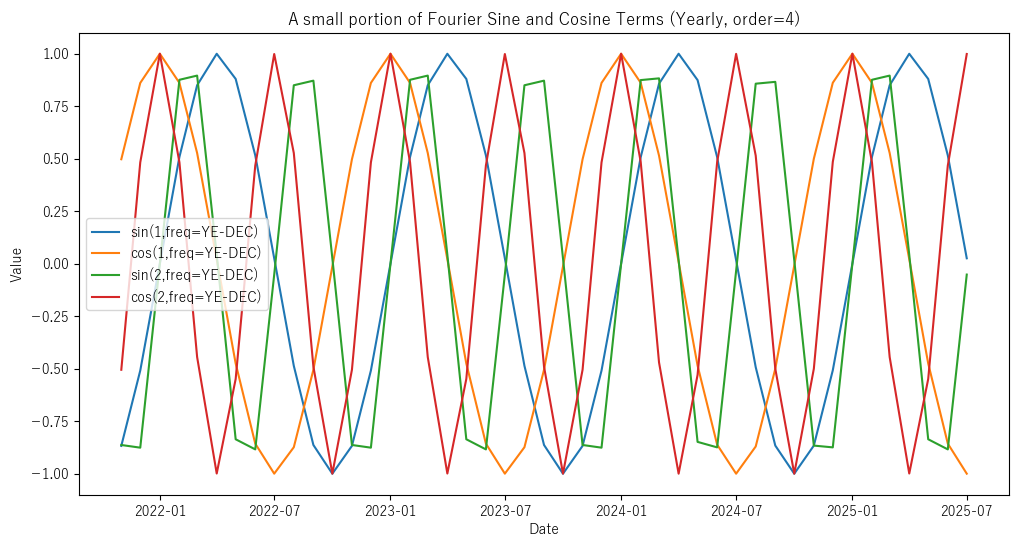

In [702]:
# Select only the Fourier columns
fourier_cols = [col for col in X.columns if 'sin' in col or 'cos' in col]

plt.figure(figsize=(12,6))

for col in fourier_cols[0:4]: # first few just for visualiation purposes
    plt.plot(X.index, X[col], label=col)

plt.title("A small portion of Fourier Sine and Cosine Terms (Yearly, order=4)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


As expected, the fourier curves were generated correctly. Let's add them to revenue:

In [703]:
revenue = revenue.merge(X, left_on='Date', right_index=True) # similar to SQL inner join

## Lags

Values could be dependent on previous values. We can use lag plots to identify these associations:

In [704]:
revenue

,Date,JP,Pickup Banner Count,Limited Banner Count,Fes Banner Count,Original Count,Collaboration Event Count,Operation Count,Rerun Count,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
0,2021-11-01,3000000.0,4,1,0,1,1,1,0,-0.867456,0.497513,-0.863142,-0.504961,8.606997e-03,-0.999963,0.871706,-0.490029
1,2021-12-01,2000000.0,3,2,0,2,0,0,0,-0.508671,0.860961,-0.875892,0.482508,-9.995463e-01,-0.030120,-0.845249,-0.534373
2,2022-01-01,6000000.0,3,2,1,2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000
3,2022-02-01,4000000.0,8,0,0,2,0,0,1,0.508671,0.860961,0.875892,0.482508,9.995463e-01,-0.030120,0.845249,-0.534373
4,2022-03-01,2000000.0,8,0,0,1,0,0,1,0.849817,0.527078,0.895839,-0.444378,9.453675e-02,-0.995521,-0.796183,-0.605056
5,2022-04-01,1900000.0,7,2,0,1,0,0,1,0.999769,0.021516,0.043022,-0.999074,-9.979172e-01,-0.064508,-0.085965,0.996298
6,2022-05-01,2000000.0,6,0,0,1,0,0,0,0.880012,-0.474951,-0.835925,-0.548843,-8.596480e-02,0.996298,0.917584,-0.397543
7,2022-06-01,4000000.0,6,0,0,1,0,1,0,0.516062,-0.856551,-0.884068,0.467359,9.984354e-01,0.055917,-0.826354,-0.563151
8,2022-07-01,10000000.0,4,2,1,2,0,1,0,0.025818,-0.999667,-0.051620,0.998667,7.738648e-02,-0.997001,-0.103102,0.994671
9,2022-08-01,6989822.0,6,2,0,2,0,0,0,-0.486273,-0.873807,0.849817,0.527078,-9.988797e-01,-0.047321,0.895839,-0.444378


In [705]:
lags = pd.DataFrame(revenue['JP'])
for lag in range(1, 9):  # 1 through 8
    lags[f'JP_lag{lag}'] = lags['JP'].shift(lag)
lags

,JP,JP_lag1,JP_lag2,JP_lag3,JP_lag4,JP_lag5,JP_lag6,JP_lag7,JP_lag8
0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000000.0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4000000.0,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN,NaN,NaN
4,2000000.0,4000000.0,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN,NaN
5,1900000.0,2000000.0,4000000.0,6000000.0,2000000.0,3000000.0,NaN,NaN,NaN
6,2000000.0,1900000.0,2000000.0,4000000.0,6000000.0,2000000.0,3000000.0,NaN,NaN
7,4000000.0,2000000.0,1900000.0,2000000.0,4000000.0,6000000.0,2000000.0,3000000.0,NaN
8,10000000.0,4000000.0,2000000.0,1900000.0,2000000.0,4000000.0,6000000.0,2000000.0,3000000.0
9,6989822.0,10000000.0,4000000.0,2000000.0,1900000.0,2000000.0,4000000.0,6000000.0,2000000.0


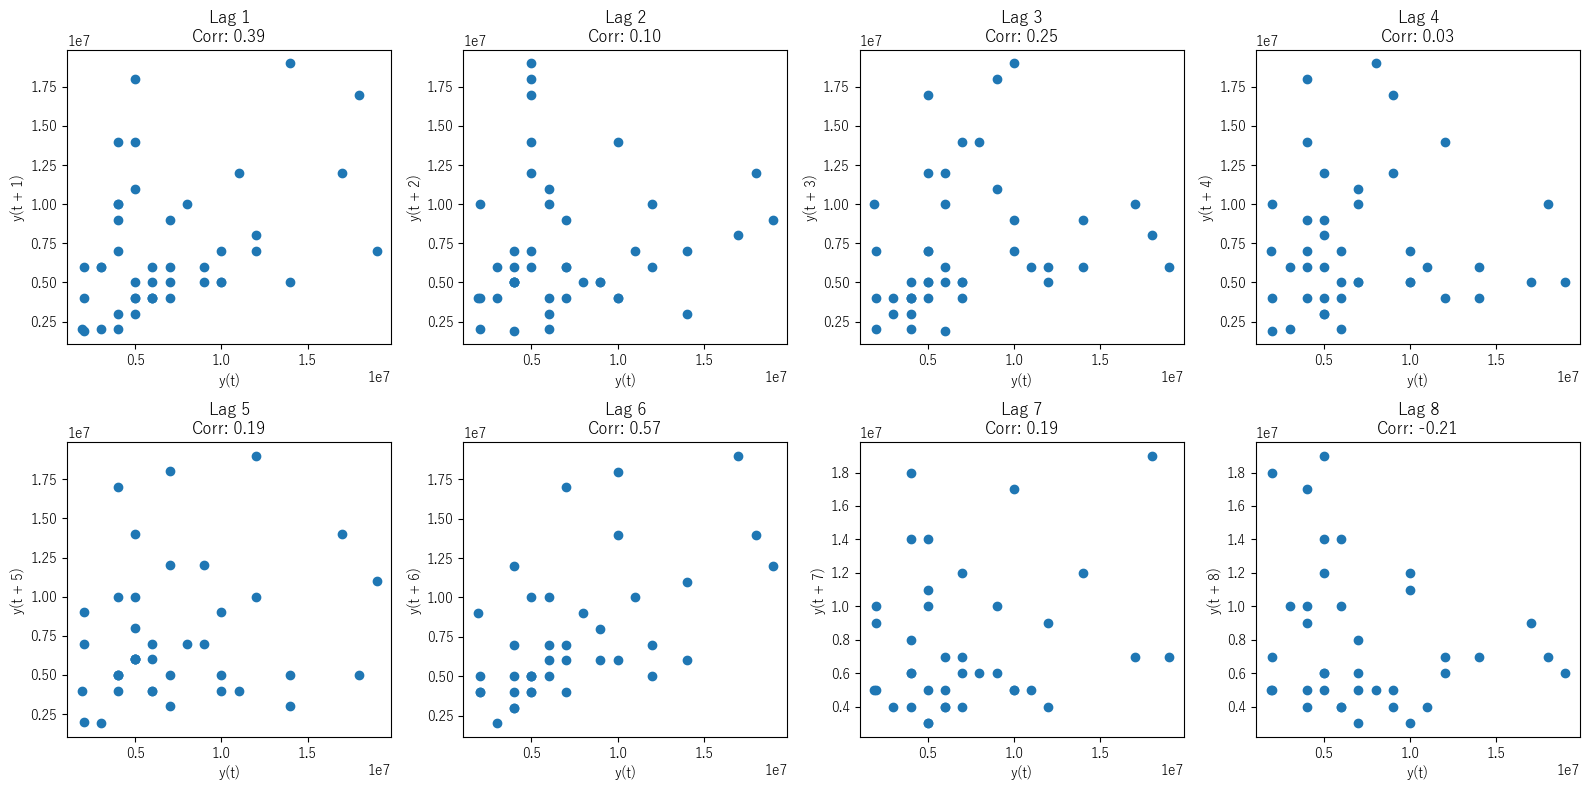

In [706]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(2, 4, figsize=(16,8))  # 2 rows x 4 columns

for i, ax in enumerate(axes.flatten(), start=1):
    lag_plot(revenue_copy['JP'], lag=i, ax=ax)

    corr = revenue_copy['JP'].autocorr(lag=i)
    ax.set_title(f"Lag {i}\nCorr: {corr:.2f}")

plt.tight_layout()
plt.show()

The lag plot does not suggest any strong serial dependence (as it looks rather randomly scattered.) Therefore, we won't use lags for our model.